# Estimating Brunt-Vaisala frequency using T and S

 In case when N$^2$ is needed but do not have 'DRHODR' saved, one can estimate it using T and S

In [38]:
import numpy as np
from MITgcmutils import rdmds, densjmd95
from hspython import loadgrid
import matplotlib.pyplot as plt

In [39]:
# Constants
rhoconst = 1.035e3
g = 9.81

Load grid information (I used loadgrid that I wrote here, but it doesn't have to be this.)

In [40]:
grd = loadgrid('so_box', varname=['XC','YC','RC','hFacC','DRC','RF'])
[nz, ny, nx] = grd.hFacC.shape

Compute the stratification frequency using DRHODR. It is defined at the center of the layer.

In [41]:
dRHOdr = rdmds('ocestrat', 9, rec=0);    # DRHODR is in the first record in "ocestrat"
Nsq = - dRHOdr*g/rhoconst*grd.mskC

Now, estimate Nsq using T and S. 
When computing "drhodr" at the layer interface, density at upper and lower cell is computed using the pressure at the interface. Nsq is defined at the layer interface.

In [42]:
T = rdmds('dynDiag', 9, rec=2)    # THETA is in the third record in "dynDiag"
S = rdmds('dynDiag', 9, rec=3)    # SALT is in the fourth record in "dynDiag"
Nsq_TS = np.zeros([nz, ny, nx])
for k in range(1,nz):
    press = -rhoconst*g*grd.RF[k]/1e4                   # pressure at the interface
    urho = densjmd95(S[k-1, :, :],T[k-1, :, :], press)  # rho at the center of the upper level
    lrho = densjmd95(S[k, :, :], T[k, :, :], press)     # rho at the center of the lower level 
    drhodr = (urho-lrho)/grd.DRC[k]*grd.mskC[k, :, :]*grd.mskC[k-1, :, :]
    Nsq_TS[k, :, :] = -drhodr*g/rhoconst

Estimating N$^2$ using "RHOAnoma" is not appropriate because "RHOAnoma" is computed using the pressure at that level 

In [43]:
rho = rdmds('ocestrat', 9, rec=1) + rhoconst    # RHOAnoma is in the second record
Nsq_ra = np.zeros([nz, ny, nx])
for k in range(1,nz):
    drhodz = (rho[k-1, :, :] - rho[k, :, :])/grd.DRC[k]*grd.mskC[k, :, :]*grd.mskC[k-1, :, :]
    Nsq_ra[k, :, :] = -drhodz*g/rhoconst

Check N$^2$

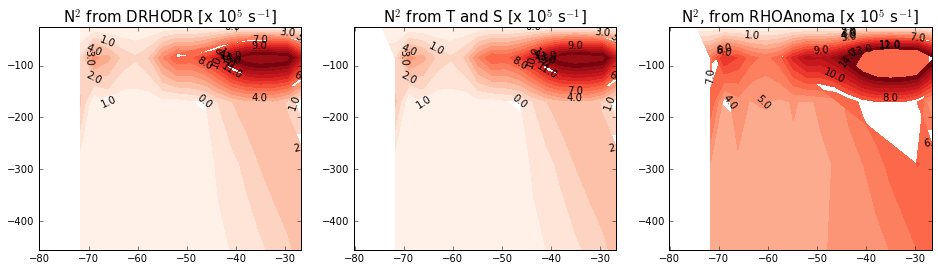

In [44]:
%matplotlib inline
showz = 5
showx = 5
scale = 1e5

X, Y = np.meshgrid(grd.YC[:, 0], grd.RC[:showz])

f, ax = plt.subplots(1, 3, figsize=(16, 4))

im = ax[0].contourf(X, Y, Nsq[:showz, :, showx]*scale, np.arange(0, 15.1 , 1), cmap='Reds')
cb = plt.clabel(im,colors='black',fmt='%3.1f')
ax[0].set_title('N$^2$ from DRHODR [x 10$^{-5}$ s$^{-2}$]', color='black', fontsize=15)

im = ax[1].contourf(X, Y, Nsq_TS[:showz,:,showx]*scale, np.arange(0,15.1,1), cmap='Reds')
cb = plt.clabel(im,colors='black',fmt='%3.1f')
ax[1].set_title('N$^2$ from T and S [x 10$^{-5}$ s$^{-2}$]', color='black', fontsize=15)

im = ax[2].contourf(X, Y, Nsq_ra[:showz,:,showx]*scale, np.arange(0,15.1,1), cmap='Reds')
cb = plt.clabel(im,colors='black',fmt='%3.1f')
ax[2].set_title('N$^2$, from RHOAnoma [x 10$^{-5}$ s$^{-2}$]', color='black', fontsize=15)